# Imports and Global Functions

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# Prepare Data

In [3]:
pc_df = pd.read_csv("./country_population.csv").sort_values(by="Country Name",ascending=True).reset_index(drop=True)
fr_df = pd.read_csv("./fertility_rate.csv").sort_values(by="Country Name",ascending=True).reset_index(drop=True)
le_df = pd.read_csv("./life_expectancy.csv").sort_values(by="Country Name",ascending=True).reset_index(drop=True)

display(pc_df)
display(fr_df)
display(le_df)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8.996351e+06,9.166764e+06,9.345868e+06,9.533954e+06,9.731361e+06,9.938414e+06,...,2.661679e+07,2.729403e+07,2.800433e+07,2.880317e+07,2.970860e+07,3.069696e+07,3.173169e+07,3.275802e+07,3.373649e+07,3.465603e+07
1,Albania,ALB,"Population, total",SP.POP.TOTL,1.608800e+06,1.659800e+06,1.711319e+06,1.762621e+06,1.814135e+06,1.864791e+06,...,2.970017e+06,2.947314e+06,2.927519e+06,2.913021e+06,2.905195e+06,2.900401e+06,2.895092e+06,2.889104e+06,2.880703e+06,2.876101e+06
2,Algeria,DZA,"Population, total",SP.POP.TOTL,1.112489e+07,1.140486e+07,1.169015e+07,1.198514e+07,1.229597e+07,1.262695e+07,...,3.430008e+07,3.486072e+07,3.546576e+07,3.611764e+07,3.681956e+07,3.756585e+07,3.833856e+07,3.911331e+07,3.987153e+07,4.060605e+07
3,American Samoa,ASM,"Population, total",SP.POP.TOTL,2.001300e+04,2.048600e+04,2.111700e+04,2.188200e+04,2.269800e+04,2.352000e+04,...,5.790300e+04,5.703000e+04,5.622700e+04,5.563700e+04,5.532000e+04,5.523000e+04,5.530700e+04,5.543700e+04,5.553700e+04,5.559900e+04
4,Andorra,AND,"Population, total",SP.POP.TOTL,1.341100e+04,1.437500e+04,1.537000e+04,1.641200e+04,1.746900e+04,1.854900e+04,...,8.268300e+04,8.386100e+04,8.446200e+04,8.444900e+04,8.375100e+04,8.243100e+04,8.078800e+04,7.922300e+04,7.801400e+04,7.728100e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,West Bank and Gaza,PSE,"Population, total",SP.POP.TOTL,NaN,NaN,NaN,NaN,NaN,NaN,...,3.494496e+06,3.596688e+06,3.702218e+06,3.811102e+06,3.927051e+06,4.046901e+06,4.169506e+06,4.294682e+06,4.422143e+06,4.551566e+06
260,World,WLD,"Population, total",SP.POP.TOTL,3.032160e+09,3.073369e+09,3.126510e+09,3.191786e+09,3.257460e+09,3.324545e+09,...,6.683228e+09,6.766303e+09,6.849573e+09,6.932881e+09,7.014999e+09,7.099549e+09,7.185078e+09,7.271228e+09,7.357370e+09,7.444027e+09
261,"Yemen, Rep.",YEM,"Population, total",SP.POP.TOTL,5.172135e+06,5.260501e+06,5.351799e+06,5.446063e+06,5.543339e+06,5.643643e+06,...,2.175160e+07,2.235639e+07,2.297493e+07,2.360678e+07,2.425221e+07,2.490997e+07,2.557632e+07,2.624633e+07,2.691621e+07,2.758421e+07
262,Zambia,ZMB,"Population, total",SP.POP.TOTL,3.044846e+06,3.140264e+06,3.240587e+06,3.345145e+06,3.452942e+06,3.563407e+06,...,1.272597e+07,1.308252e+07,1.345642e+07,1.385003e+07,1.426476e+07,1.469994e+07,1.515321e+07,1.562097e+07,1.610059e+07,1.659139e+07


,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Afghanistan,AFG,"Fertility rate, total (births per woman)",SP.DYN.TFRT.IN,7.450000,7.450000,7.45000,7.450000,7.450000,7.450000,...,6.46000,6.254000,6.038000,5.816000,5.595000,5.380000,5.174000,4.981000,4.802000,4.635000
1,Albania,ALB,"Fertility rate, total (births per woman)",SP.DYN.TFRT.IN,6.489000,6.401000,6.28200,6.133000,5.960000,5.773000,...,1.66800,1.650000,1.646000,1.653000,1.668000,1.685000,1.700000,1.710000,1.714000,1.713000
2,Algeria,DZA,"Fertility rate, total (births per woman)",SP.DYN.TFRT.IN,7.524000,7.573000,7.61400,7.646000,7.665000,7.675000,...,2.66200,2.749000,2.828000,2.889000,2.925000,2.936000,2.924000,2.890000,2.839000,2.776000
3,American Samoa,ASM,"Fertility rate, total (births per woman)",SP.DYN.TFRT.IN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Andorra,AND,"Fertility rate, total (births per woman)",SP.DYN.TFRT.IN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.18000,1.250000,1.190000,1.270000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,West Bank and Gaza,PSE,"Fertility rate, total (births per woman)",SP.DYN.TFRT.IN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.62300,4.554000,4.487000,4.419000,4.350000,4.281000,4.212000,4.143000,4.075000,4.008000
260,World,WLD,"Fertility rate, total (births per woman)",SP.DYN.TFRT.IN,4.984026,5.011695,5.03659,5.058067,5.068204,5.049588,...,2.55264,2.542093,2.523626,2.508023,2.491963,2.483746,2.468328,2.461479,2.451845,2.439026
261,"Yemen, Rep.",YEM,"Fertility rate, total (births per woman)",SP.DYN.TFRT.IN,7.488000,7.531000,7.57500,7.621000,7.665000,7.705000,...,5.09000,4.940000,4.801000,4.674000,4.554000,4.440000,4.327000,4.215000,4.104000,3.995000
262,Zambia,ZMB,"Fertility rate, total (births per woman)",SP.DYN.TFRT.IN,7.115000,7.169000,7.21400,7.249000,7.274000,7.291000,...,5.64200,5.561000,5.478000,5.397000,5.318000,5.242000,5.171000,5.104000,5.041000,4.981000


,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Afghanistan,AFG,"Life expectancy at birth, total (years)",SP.DYN.LE00.IN,32.292000,32.742000,33.185000,33.62400,34.060000,34.495000,...,59.694000,60.243000,60.754000,61.226000,61.666000,62.086000,62.494000,62.895000,63.288000,63.673000
1,Albania,ALB,"Life expectancy at birth, total (years)",SP.DYN.LE00.IN,62.279000,63.298000,64.187000,64.91100,65.461000,65.848000,...,75.656000,75.943000,76.281000,76.652000,77.031000,77.389000,77.702000,77.963000,78.174000,78.345000
2,Algeria,DZA,"Life expectancy at birth, total (years)",SP.DYN.LE00.IN,46.138000,46.596000,47.054000,47.50700,47.956000,48.392000,...,73.648000,74.032000,74.374000,74.676000,74.944000,75.187000,75.418000,75.641000,75.860000,76.078000
3,American Samoa,ASM,"Life expectancy at birth, total (years)",SP.DYN.LE00.IN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Andorra,AND,"Life expectancy at birth, total (years)",SP.DYN.LE00.IN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,West Bank and Gaza,PSE,"Life expectancy at birth, total (years)",SP.DYN.LE00.IN,NaN,NaN,NaN,NaN,NaN,NaN,...,71.942000,72.110000,72.277000,72.444000,72.613000,72.783000,72.954000,73.126000,73.299000,73.473000
260,World,WLD,"Life expectancy at birth, total (years)",SP.DYN.LE00.IN,52.571658,53.077473,53.501598,54.03553,54.715222,55.384527,...,69.794308,70.083463,70.405607,70.682937,70.971832,71.215332,71.460066,71.694029,71.856935,72.035264
261,"Yemen, Rep.",YEM,"Life expectancy at birth, total (years)",SP.DYN.LE00.IN,34.361000,34.471000,34.739000,35.18700,35.815000,36.597000,...,62.552000,62.888000,63.208000,63.508000,63.786000,64.046000,64.291000,64.523000,64.743000,64.953000
262,Zambia,ZMB,"Life expectancy at birth, total (years)",SP.DYN.LE00.IN,45.124000,45.502000,45.869000,46.22500,46.574000,46.929000,...,52.313000,53.749000,55.194000,56.588000,57.872000,59.011000,59.982000,60.775000,61.397000,61.874000


In [4]:
pc_df[:1]

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996351.0,9166764.0,9345868.0,9533954.0,9731361.0,9938414.0,...,26616792.0,27294031.0,28004331.0,28803167.0,29708599.0,30696958.0,31731688.0,32758020.0,33736494.0,34656032.0


In [5]:
assert pc_df["Country Name"].to_list() == fr_df["Country Name"].to_list() == le_df["Country Name"].to_list()
assert pc_df["Country Code"].to_list() == fr_df["Country Code"].to_list() == le_df["Country Code"].to_list()
countries_df = pc_df["Country Code"].to_list()
display(countries_df)

['AFG',
 'ALB',
 'DZA',
 'ASM',
 'AND',
 'AGO',
 'ATG',
 'ARB',
 'ARG',
 'ARM',
 'ABW',
 'AUS',
 'AUT',
 'AZE',
 'BHS',
 'BHR',
 'BGD',
 'BRB',
 'BLR',
 'BEL',
 'BLZ',
 'BEN',
 'BMU',
 'BTN',
 'BOL',
 'BIH',
 'BWA',
 'BRA',
 'VGB',
 'BRN',
 'BGR',
 'BFA',
 'BDI',
 'CPV',
 'KHM',
 'CMR',
 'CAN',
 'CSS',
 'CYM',
 'CAF',
 'CEB',
 'TCD',
 'CHI',
 'CHL',
 'CHN',
 'COL',
 'COM',
 'COD',
 'COG',
 'CRI',
 'CIV',
 'HRV',
 'CUB',
 'CUW',
 'CYP',
 'CZE',
 'DNK',
 'DJI',
 'DMA',
 'DOM',
 'EAR',
 'EAS',
 'TEA',
 'EAP',
 'ECU',
 'EGY',
 'SLV',
 'GNQ',
 'ERI',
 'EST',
 'ETH',
 'EMU',
 'ECS',
 'TEC',
 'ECA',
 'EUU',
 'FRO',
 'FJI',
 'FIN',
 'FCS',
 'FRA',
 'PYF',
 'GAB',
 'GMB',
 'GEO',
 'DEU',
 'GHA',
 'GIB',
 'GRC',
 'GRL',
 'GRD',
 'GUM',
 'GTM',
 'GIN',
 'GNB',
 'GUY',
 'HTI',
 'HPC',
 'HIC',
 'HND',
 'HKG',
 'HUN',
 'IBD',
 'IBT',
 'IDB',
 'IDX',
 'IDA',
 'ISL',
 'IND',
 'IDN',
 'IRN',
 'IRQ',
 'IRL',
 'IMN',
 'ISR',
 'ITA',
 'JAM',
 'JPN',
 'JOR',
 'KAZ',
 'KEN',
 'KIR',
 'PRK',
 'KOR',
 'XKX',


USA
Country Population


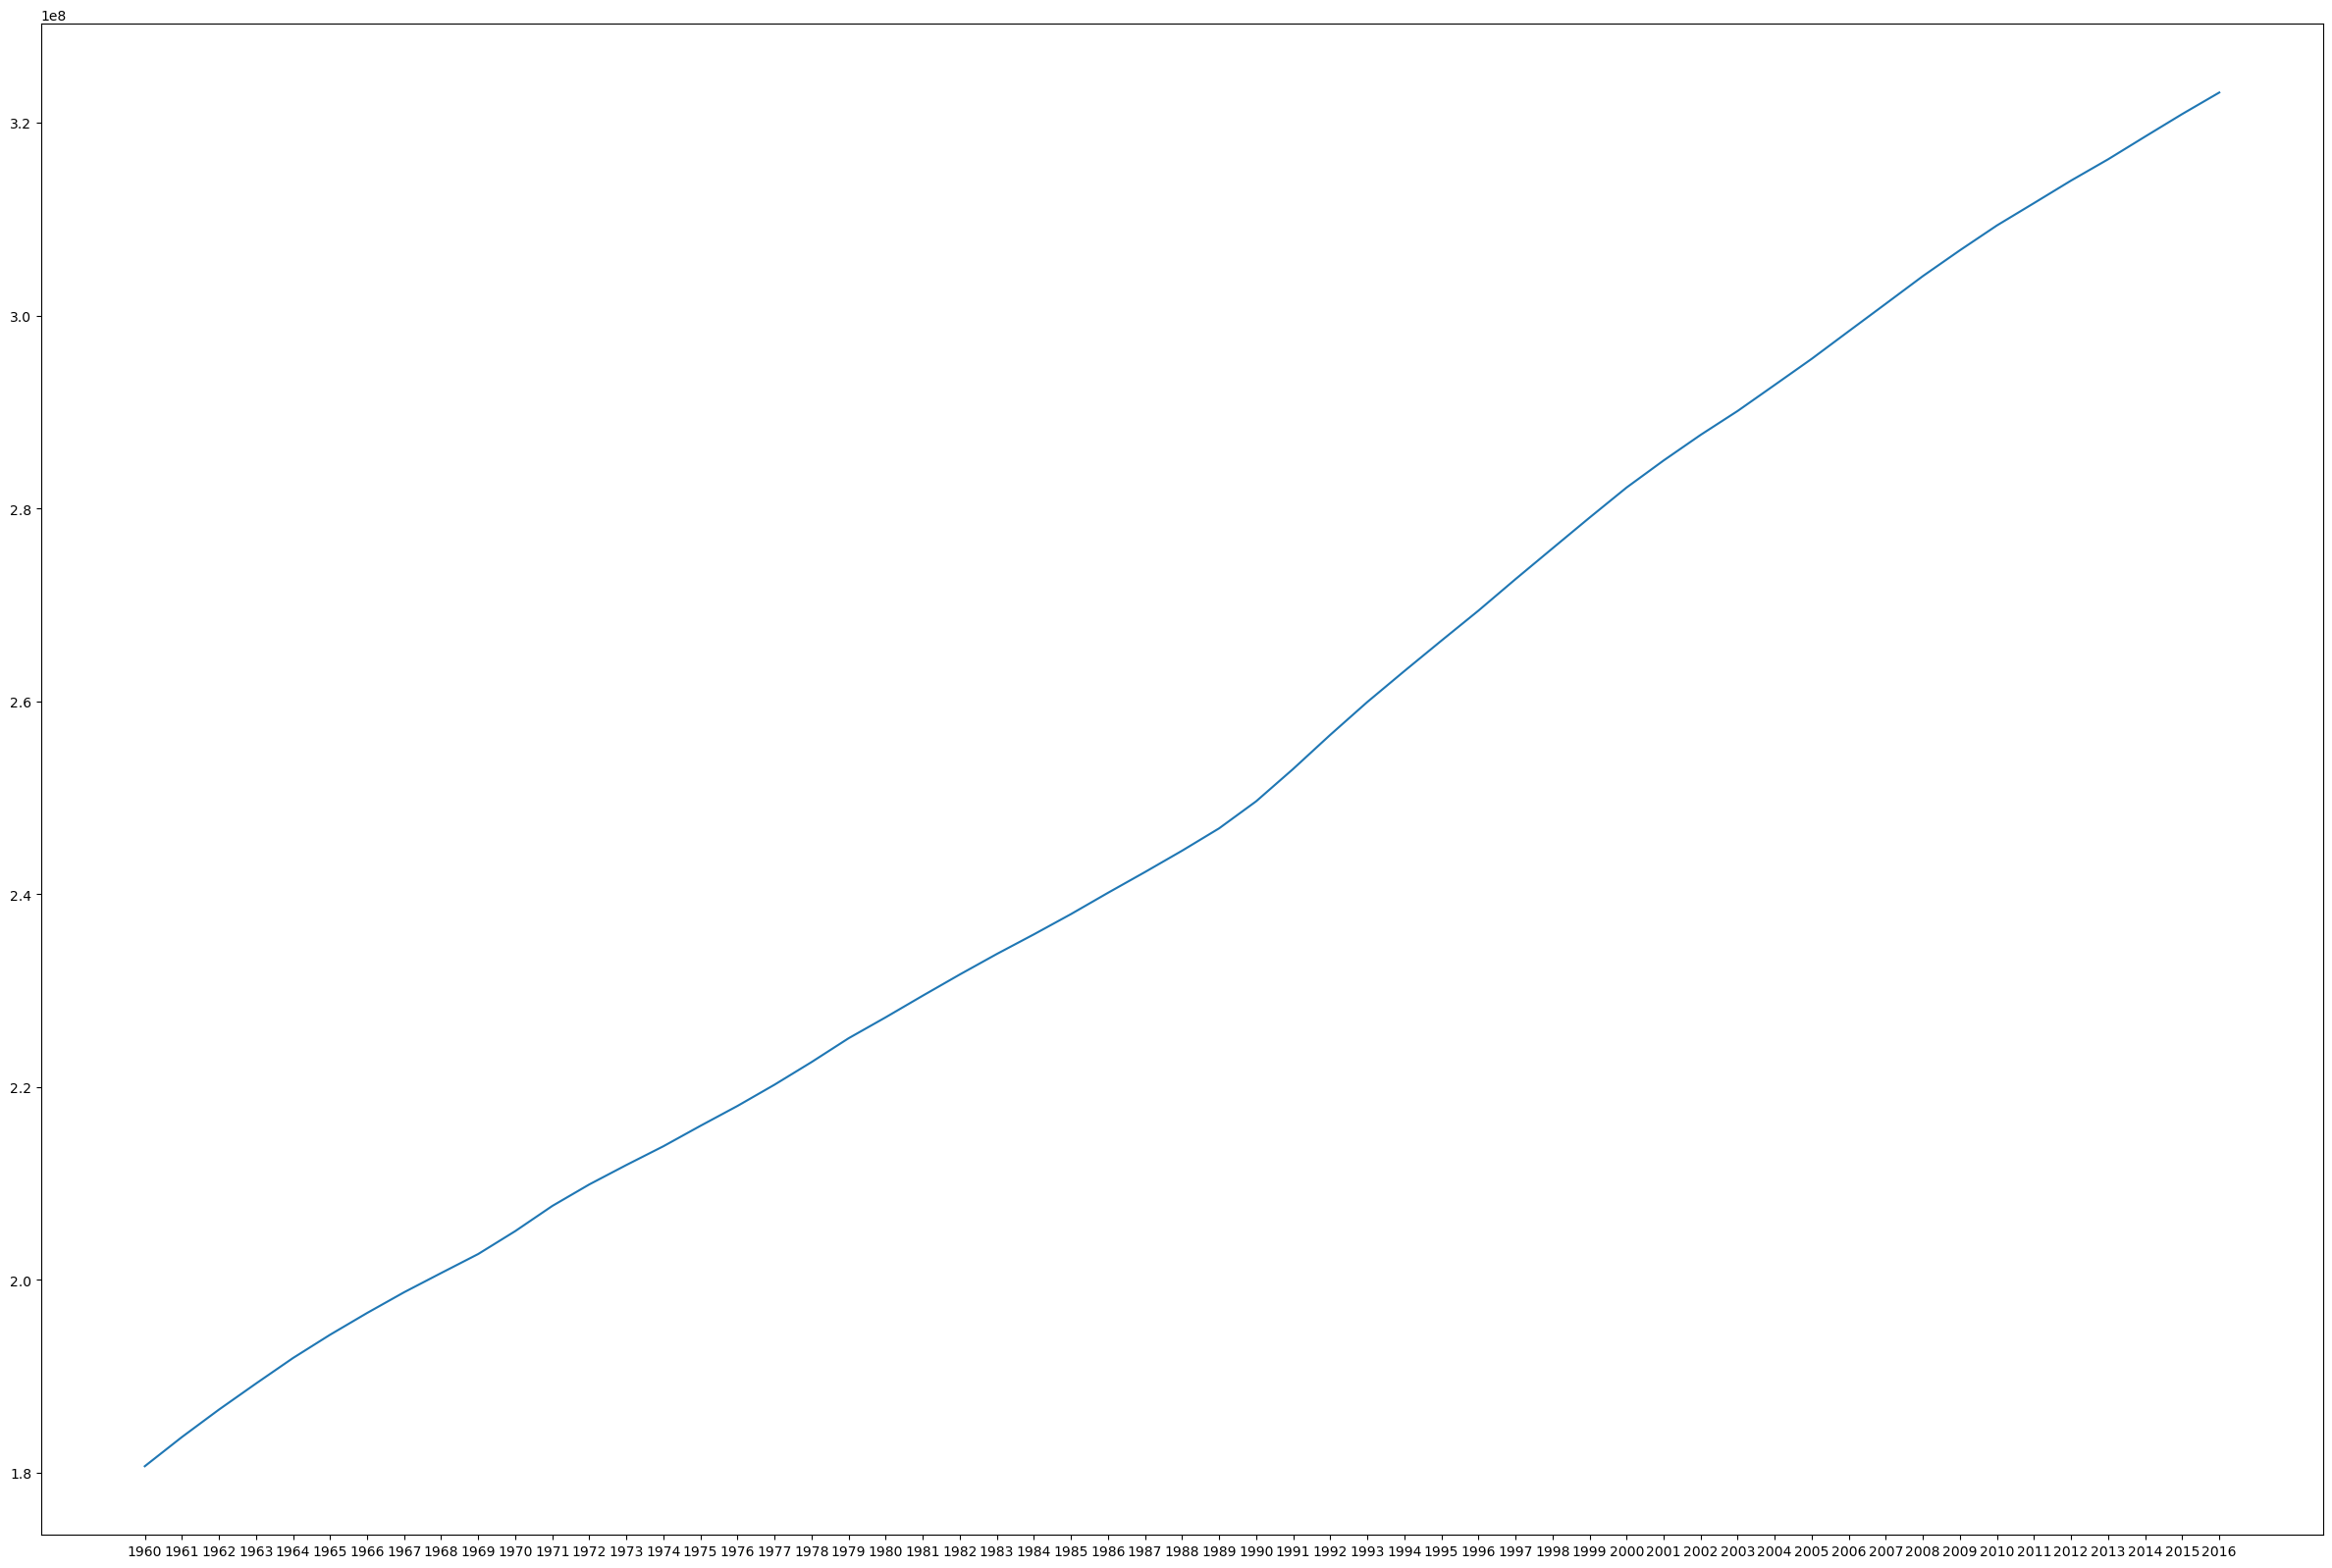

Fertility Rate


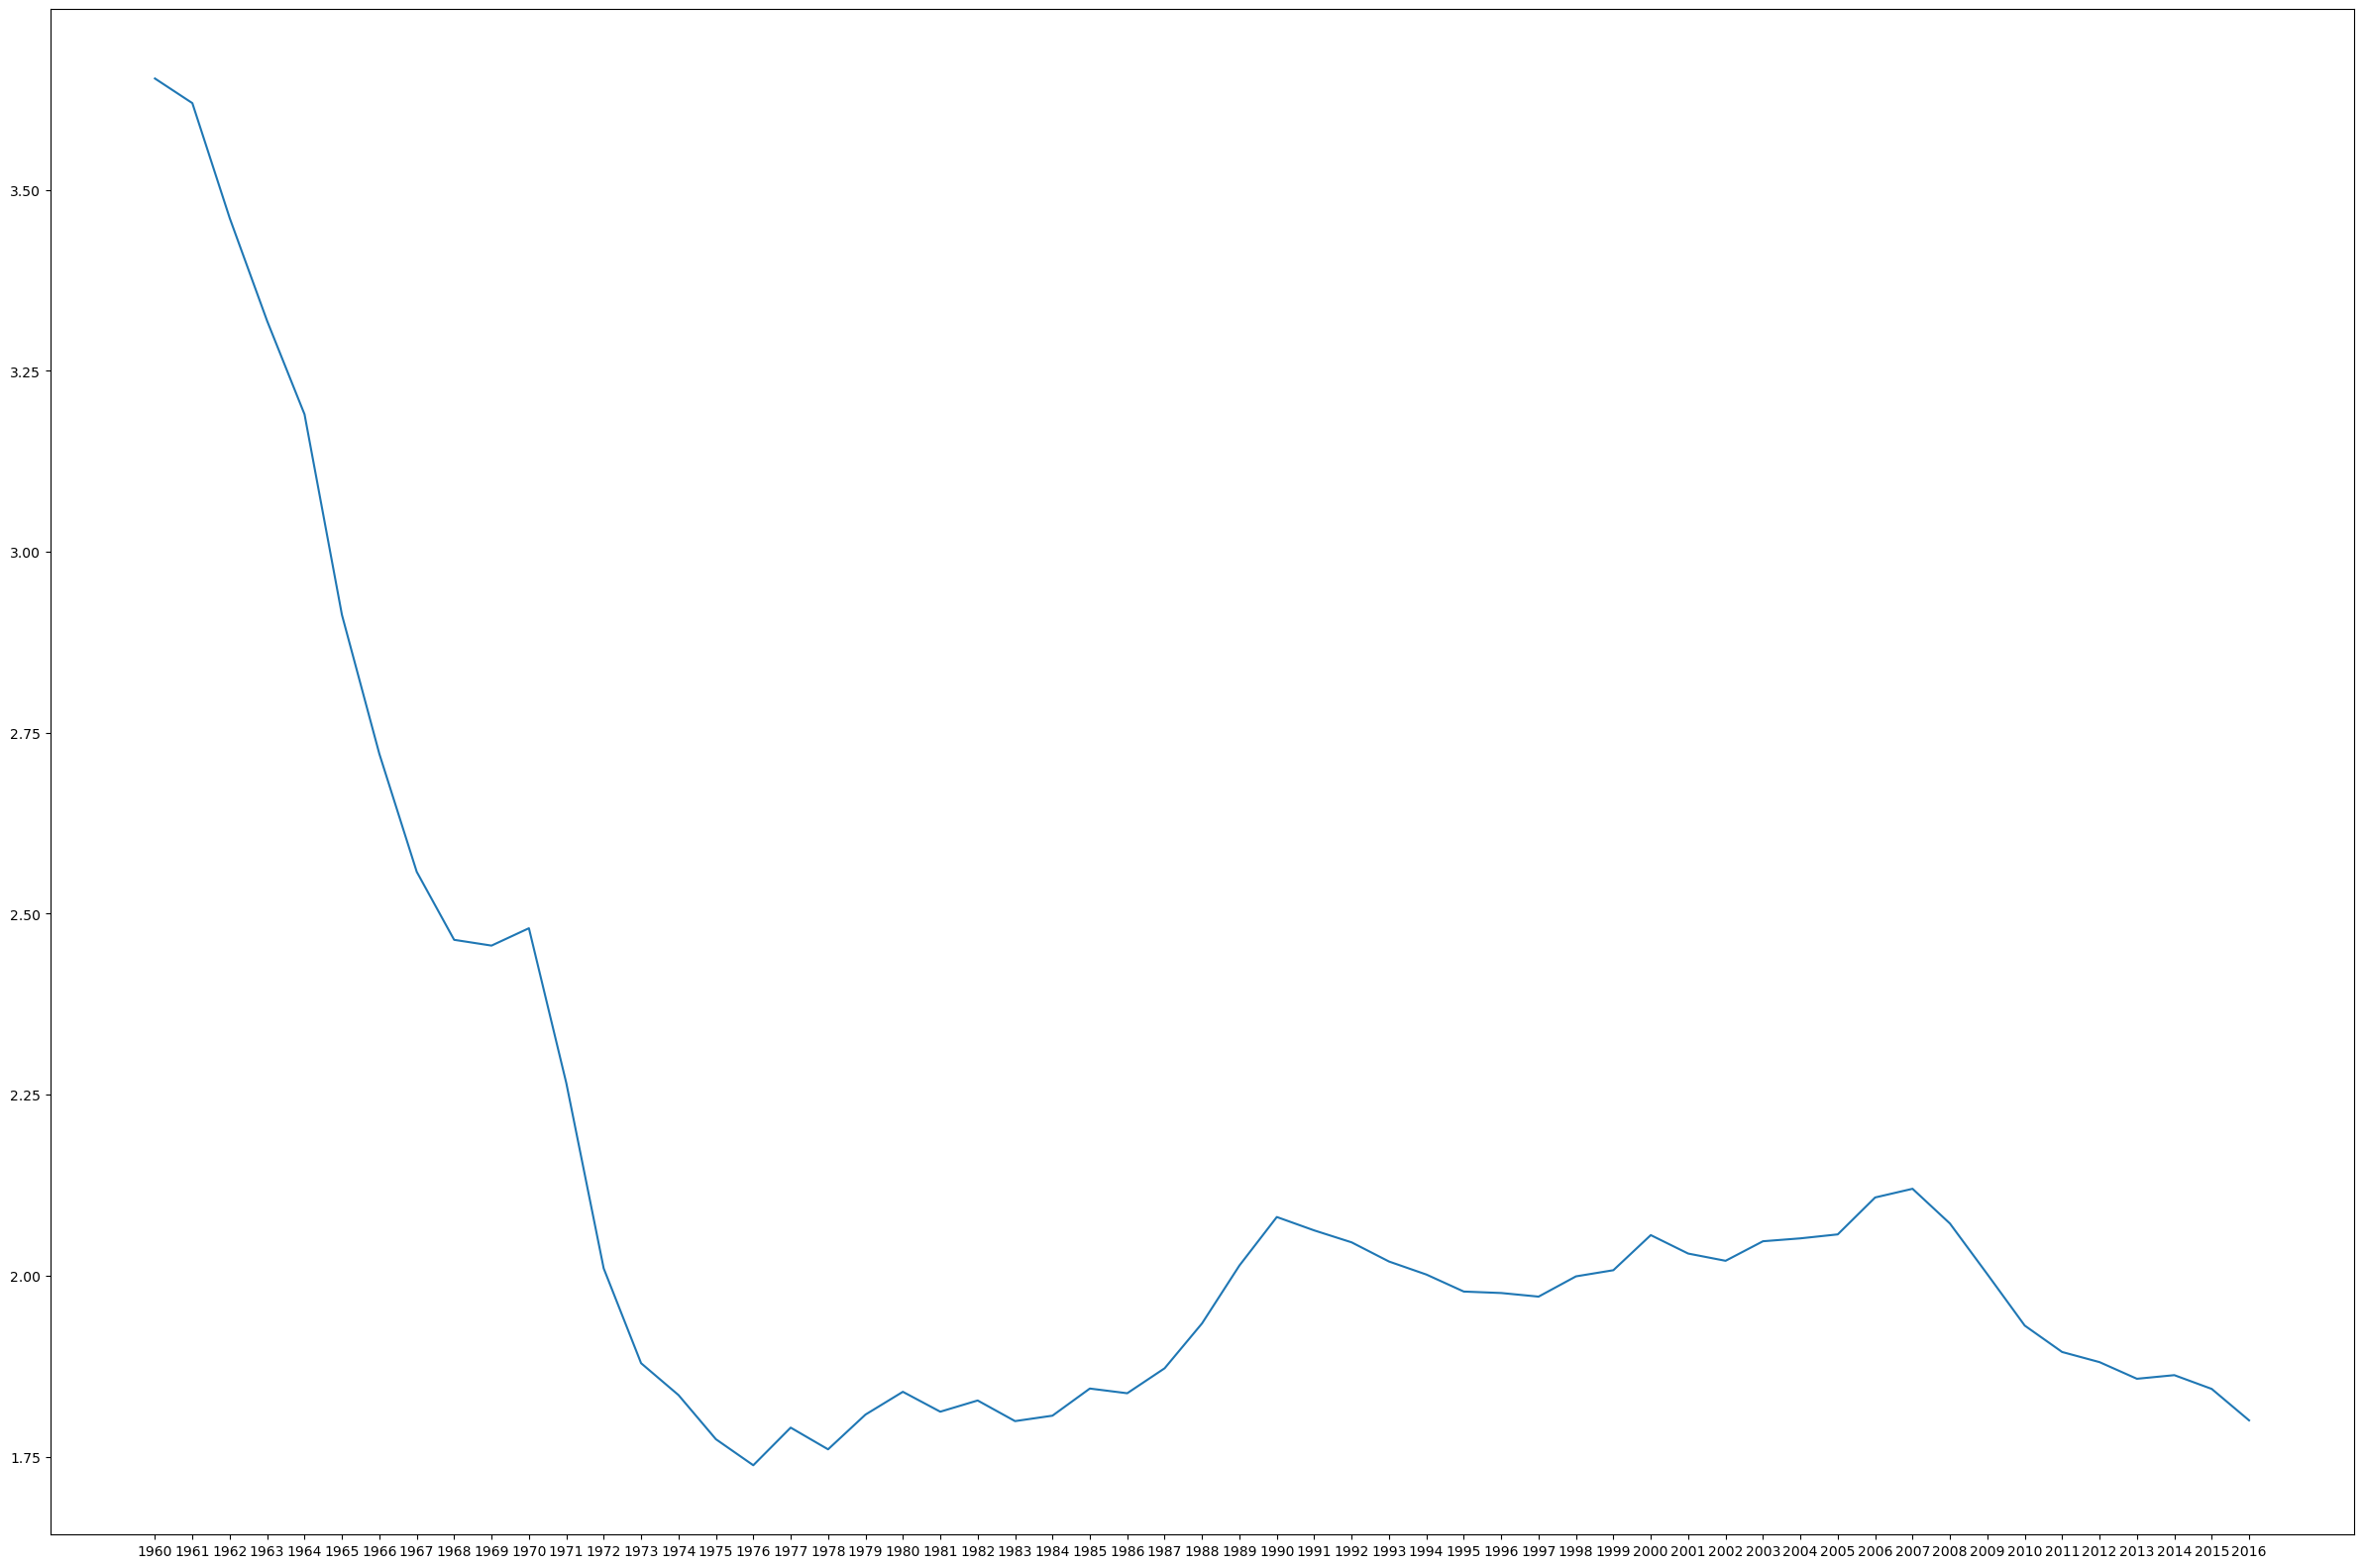

Life Expectancy


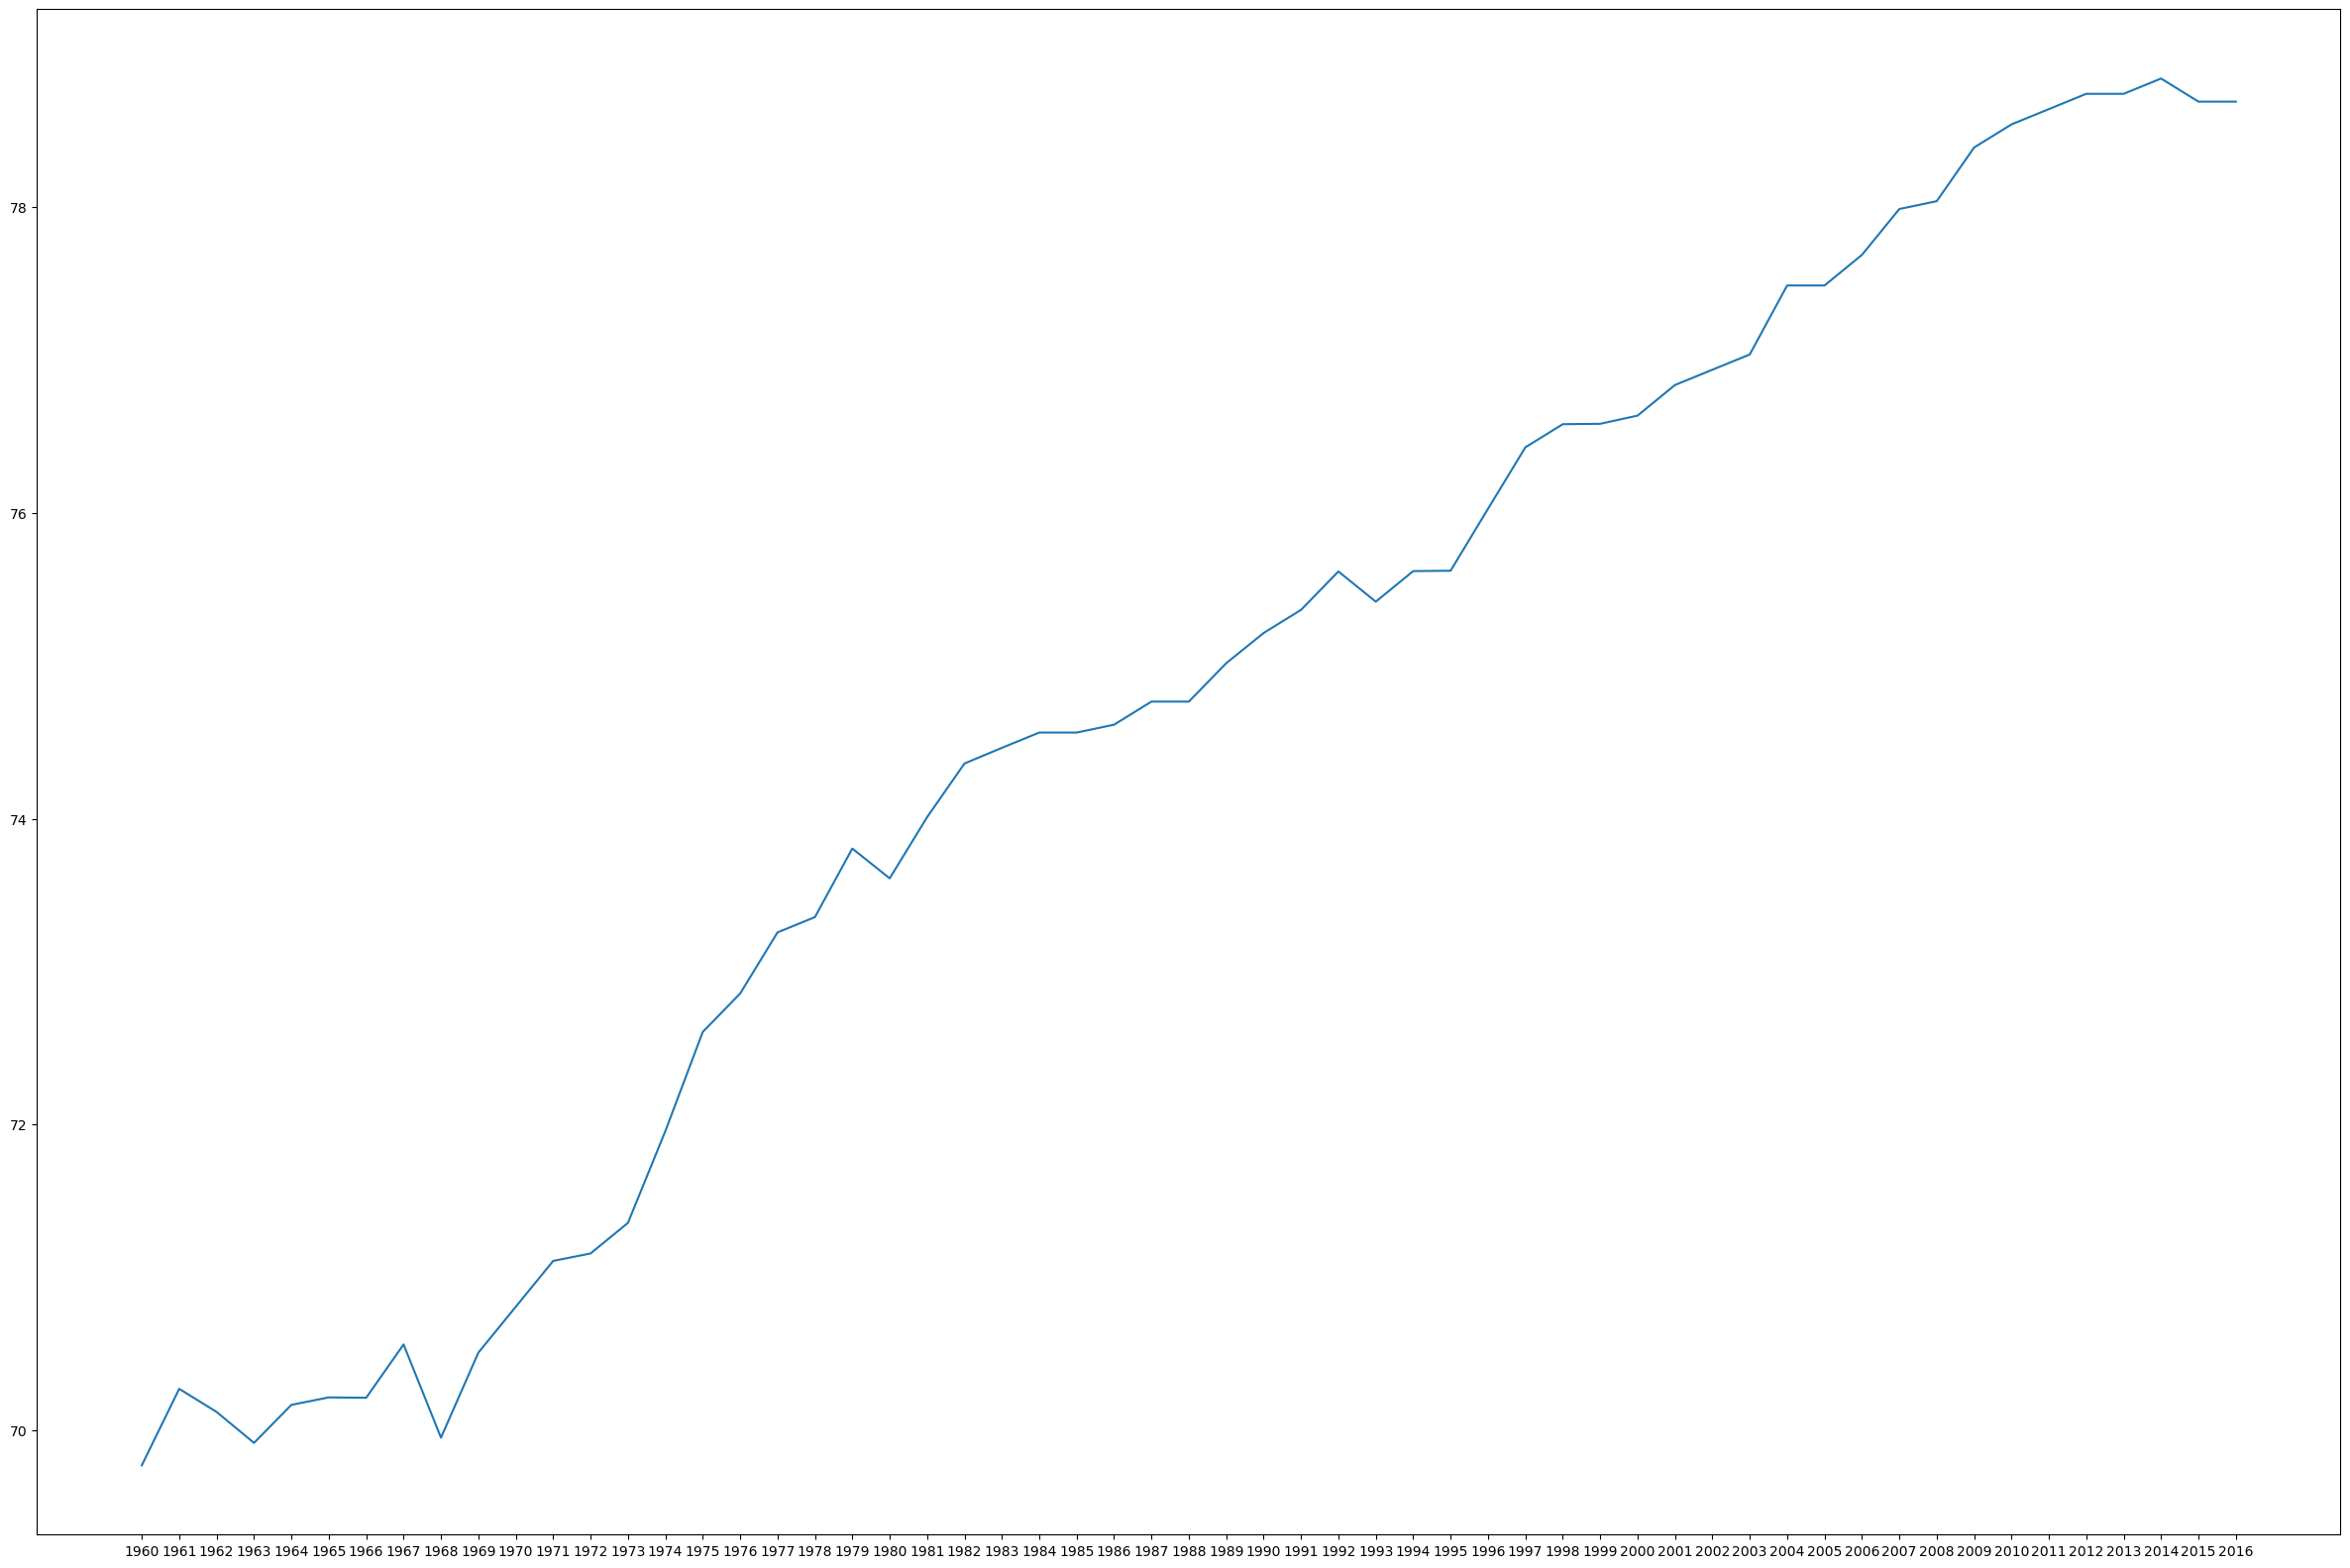

In [6]:
#print("AFG")
#y = pc_df.loc[pc_df["Country Code"] == "AFG"].drop(["Country Name","Country Code","Indicator Name","Indicator Code"], axis=1).to_numpy()[0]
#x = np.array(pc_df.loc[pc_df["Country Code"] == "AFG"].drop(["Country Name","Country Code","Indicator Name","Indicator Code"], axis=1).columns)
#fig, ax = plt.subplots()
#fig.set_size_inches(30,20)
#ax.plot(x,y)
#plt.show()

#print("PRT")
#y = pc_df.loc[pc_df["Country Code"] == "PRT"].drop(["Country Name","Country Code","Indicator Name","Indicator Code"], axis=1).to_numpy()[0]
#x = np.array(pc_df.loc[pc_df["Country Code"] == "PRT"].drop(["Country Name","Country Code","Indicator Name","Indicator Code"], axis=1).columns)
#fig, ax = plt.subplots()
#fig.set_size_inches(30,20)
#ax.plot(x,y)
#plt.show()

print("USA")

print("Country Population")
y = pc_df.loc[pc_df["Country Code"] == "USA"].drop(["Country Name","Country Code","Indicator Name","Indicator Code"], axis=1).to_numpy()[0]
x = np.array(pc_df.loc[pc_df["Country Code"] == "USA"].drop(["Country Name","Country Code","Indicator Name","Indicator Code"], axis=1).columns)
fig, ax = plt.subplots()
fig.set_size_inches(30,20)
ax.plot(x,y)
plt.show()

print("Fertility Rate")
y = fr_df.loc[fr_df["Country Code"] == "USA"].drop(["Country Name","Country Code","Indicator Name","Indicator Code"], axis=1).to_numpy()[0]
x = np.array(fr_df.loc[fr_df["Country Code"] == "USA"].drop(["Country Name","Country Code","Indicator Name","Indicator Code"], axis=1).columns)
fig, ax = plt.subplots()
fig.set_size_inches(30,20)
ax.plot(x,y)
plt.show()

print("Life Expectancy")
y = le_df.loc[le_df["Country Code"] == "USA"].drop(["Country Name","Country Code","Indicator Name","Indicator Code"], axis=1).to_numpy()[0]
x = np.array(le_df.loc[le_df["Country Code"] == "USA"].drop(["Country Name","Country Code","Indicator Name","Indicator Code"], axis=1).columns)
fig, ax = plt.subplots()
fig.set_size_inches(30,20)
ax.plot(x,y)
plt.show()

#print("RUS")
#y = pc_df.loc[pc_df["Country Code"] == "RUS"].drop(["Country Name","Country Code","Indicator Name","Indicator Code"], axis=1).to_numpy()[0]
#x = np.array(pc_df.loc[pc_df["Country Code"] == "RUS"].drop(["Country Name","Country Code","Indicator Name","Indicator Code"], axis=1).columns)
#fig, ax = plt.subplots()
#fig.set_size_inches(30,20)
#ax.plot(x,y)
#plt.show()

#print("GBR")
#y = pc_df.loc[pc_df["Country Code"] == "GBR"].drop(["Country Name","Country Code","Indicator Name","Indicator Code"], axis=1).to_numpy()[0]
#x = np.array(pc_df.loc[pc_df["Country Code"] == "GBR"].drop(["Country Name","Country Code","Indicator Name","Indicator Code"], axis=1).columns)
#fig, ax = plt.subplots()
#fig.set_size_inches(30,20)
#ax.plot(x,y)
#plt.show()